In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from glob import glob
import matplotlib.pyplot as plt

In [13]:
#based on https://www.kaggle.com/code/pankul/image-classification-w-vgg16-weights
IMAGE_SIZE = [100, 100]  
batch_size = 64
nb_epochs = 10
train_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training'
test_data_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test'

# getting the number of classes i.e. type of fruits
folders = glob(train_data_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 131


# VGG-16 Fine-tuning

We use the pre-trained weights of the VGG-16 model trained on ImageNet dataset. We take the outputs of the last convolutional block (so same inputs that go into the first fully-connected layer) which produces 4096 outputs. We train on top a classifier with the following architechture:
* Dropout
* FC-1024 + ReLU
* FC-256 + ReLU
* Output layer with softmax
Model is trained on rescaled to [0, 1] data using ADAM optimized and cross-entropy loss.

# Training strategy

First, we freeze the VGG-16 convolutional layers and train just the classifier for 10 epochs. Then, we 

In [16]:
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dropout(0.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(num_classes, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = x)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [17]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [18]:
datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_data_dir,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_gen = datagen.flow_from_directory(
    test_data_dir,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [34]:
# csv_logger=CSVLogger('VGG-16_full_freeze.log',separator=",",append=False)

# history = model.fit(
#     train_gen,  
#     epochs = 15,  
#     validation_data = test_gen,
#     callbacks=[csv_logger,]
# ) 

model.save('VGG-16_full_freeze')

In [60]:
history = pd.read_csv('VGG-16_full_freeze.log')

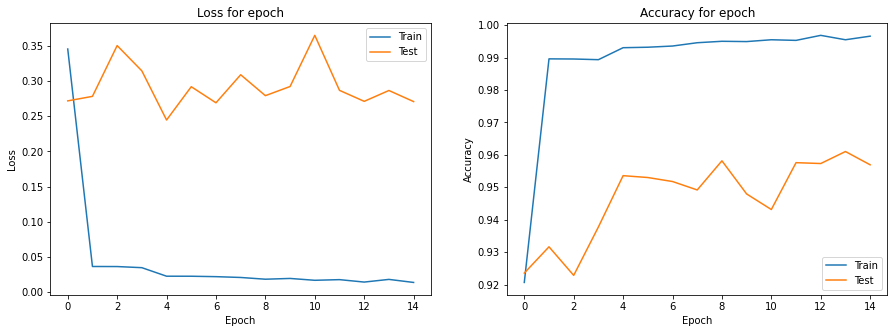

Final test accuracy before fine-tuning: 95.69%


In [64]:
epochs = range(len(history))

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)

plt.title("Loss for epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.loss, label='Train')
plt.plot(history.val_loss, label='Test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy for epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.acc, label='Train')
plt.plot(history.val_acc, label='Test')
plt.legend()

plt.show();

print(f'Final test accuracy before fine-tuning: {np.round(100 * history.val_acc.iloc[-1], 2)}%')

The model seems to have converged (more or less, though the test statistic is still quite volatile). Now we can fine-tune the weights of the whole model. We also use a smaller learning rate, since now there much more parameters to train.

In [42]:
model = keras.models.load_model('VGG-16_full_freeze')

In [43]:
for layer in model.layers:
    model.trainable = True

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['acc']
)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [74]:
# csv_logger=CSVLogger('VGG-16_fine_tune.log',separator=",",append=True)

# history_fine_tune = model.fit(
#     train_gen,  
#     epochs = 10,  
#     validation_data = test_gen,
#     callbacks=[csv_logger,]
# ) 

# model.save('VGG-16_fine_tune')

In [77]:
history_fine_tune = pd.read_csv('VGG-16_fine_tune.log')
history_all = pd.concat([history, history_fine_tune]).reset_index(drop=True)

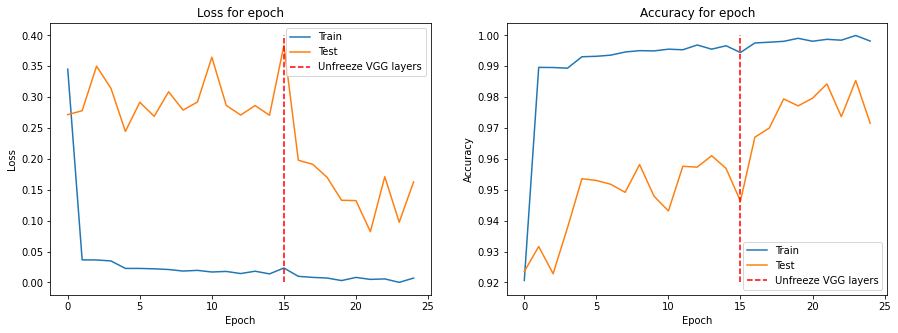

Final test accuracy: 97.16%


In [100]:
epochs = range(len(history_all))

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)

plt.title("Loss for epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history_all.loss, label='Train')
plt.plot(history_all.val_loss, label='Test')
plt.vlines(15, 0, 0.4, color='red', linestyles='dashed', label='Unfreeze VGG layers')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy for epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history_all.acc, label='Train')
plt.plot(history_all.val_acc, label='Test')
plt.vlines(15, 0.92, 1, color='red', linestyles='dashed', label='Unfreeze VGG layers')
plt.legend()

plt.show();

print(f'Final test accuracy: {np.round(100 * history_all.val_acc.iloc[-1], 2)}%')

After 10 epochs of fine-tuning the model converged to a better state.

# Final results of VGG-16

In [102]:
def convert(x):
    return f'{np.round(100 * x, 2)}%'

res = pd.DataFrame(
    [
        ['VGG-16 Frozen + Classifier', '15', convert(history.acc.iloc[-1]), convert(history.val_acc.iloc[-1])],
        ['VGG-16 Fine-tuned', '15 + 10', convert(history_all.acc.iloc[-1]), convert(history_all.val_acc.iloc[-1])],
    ],
    columns=['Model', 'N Epochs', 'Train', 'Test']
).set_index('Model')
res.to_csv('results_VGG.csv')

In [103]:
res = pd.read_csv('results_VGG.csv')
res

,Model,N Epochs,Train,Test
0,VGG-16 Frozen + Classifier,15,99.66%,95.69%
1,VGG-16 Fine-tuned,15 + 10,99.82%,97.16%
